# Analyzing Album Sales using Joins



In [8]:
import sqlite3
import matplotlib.pyplot as plt

In [9]:
# Establish a connection to your SQLite database
db_path = 'chinook.db'
conn = sqlite3.connect(db_path)

In [10]:
# %%capture
# %load_ext sql
# %sql sqlite:///chinook.db

In [11]:
sq1 = """
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view")
"""

In [12]:
# %%sql
# SELECT
#     name,
#     type
# FROM sqlite_master
# WHERE type IN ("table","view");

In [13]:
# Execute the query and fetch all results
cursor = conn.cursor()
cursor.execute(sq1)
rows1 = cursor.fetchall()

In [14]:
# # Close the connection
# conn.close()

In [15]:
sq2 = """
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
"""

In [16]:
# Execute the query and fetch all results
cursor = conn.cursor()
cursor.execute(sq2)
rows2 = cursor.fetchall()

In [ ]:
# %%sql
# WITH usa_tracks_sold AS
#    (
#     SELECT il.* FROM invoice_line il
#     INNER JOIN invoice i on il.invoice_id = i.invoice_id
#     INNER JOIN customer c on i.customer_id = c.customer_id
#     WHERE c.country = "USA"
#    )

# SELECT
#     g.name genre,
#     count(uts.invoice_line_id) tracks_sold,
#     cast(count(uts.invoice_line_id) AS FLOAT) / (
#         SELECT COUNT(*) from usa_tracks_sold
#     ) percentage_sold
# FROM usa_tracks_sold uts
# INNER JOIN track t on t.track_id = uts.track_id
# INNER JOIN genre g on g.genre_id = t.genre_id
# GROUP BY 1
# ORDER BY 2 DESC
# LIMIT 10;

In [17]:
# # Close the connection
# conn.close()

In [18]:
genres = [row[0] for row in rows2]
tracks_sold = [row[1] for row in rows2]

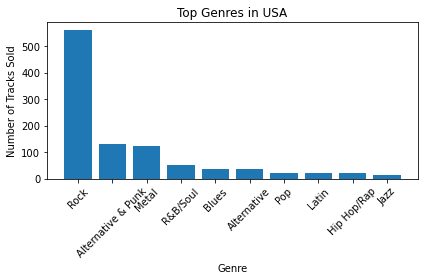

In [19]:
# Visualize using matplotlib
plt.bar(genres, tracks_sold)
plt.title('Top Genres in USA')
plt.xlabel('Genre')
plt.ylabel('Number of Tracks Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Summary of findings from above

## Support Team Performance

Do support team member assignments affect number of sales?
* Incorporate extraneous (customer) variables from other columns as explanatory, where possible.

The following query includes a normalization of the support team members' time-in-position (TIP) to account for the fact that some team members have been in their position longer than others.  The TIP is calculated as the number of days since the team member's hire date to today.  Then 

In [21]:
sq3 = """
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
    SUM(csrs.total) / (JULIANDAY('now') - JULIANDAY(e.hire_date)) as sales_per_day_since_hire
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
"""

variance may be a reflection of date of hire.

## Sales by Country

Things

In [ ]:
%%sql
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );

# Execute the query and fetch all results
cursor = conn.cursor()
cursor.execute(sql_query)
rows = cursor.fetchall()

# Assume column names are 'country' and 'total_sales' based on your query
countries = [row[0] for row in rows]
total_sales = [row[2] for row in rows]

# Close the connection
conn.close()

# Visualize using matplotlib
plt.bar(countries, total_sales)
plt.title('Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales in USD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Summary of Findings
findings

## Album vs. Individual Track


In [ ]:
%%sql

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;

Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.